# <span style="color:blue"> Sign language digit recognition (ResNet) </span>

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform
from tensorflow.keras.models import Model
tfl = tf.keras.layers

In [3]:
loc = './data/'
print(f"load train data:")
train_hdf = h5py.File(loc+'signs_train.h5', 'r')
print(f"list of keys in train dataset: {list(train_hdf.keys())}")
X_train = np.array(train_hdf.get('train_set_x'))/255
y_train = np.array(train_hdf.get('train_set_y'))
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")

print(f"load test data:")
test_hdf = h5py.File(loc+'signs_test.h5', 'r')
print(f"list of keys in test dataset: {list(test_hdf.keys())}")
X_test = np.array(test_hdf.get('test_set_x'))/255
y_test = np.array(test_hdf.get('test_set_y'))
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

load train data:
list of keys in train dataset: ['list_classes', 'train_set_x', 'train_set_y']
X_train.shape = (1080, 64, 64, 3)
y_train.shape = (1080,)
load test data:
list of keys in test dataset: ['list_classes', 'test_set_x', 'test_set_y']
X_test.shape = (120, 64, 64, 3)
y_test.shape = (120,)


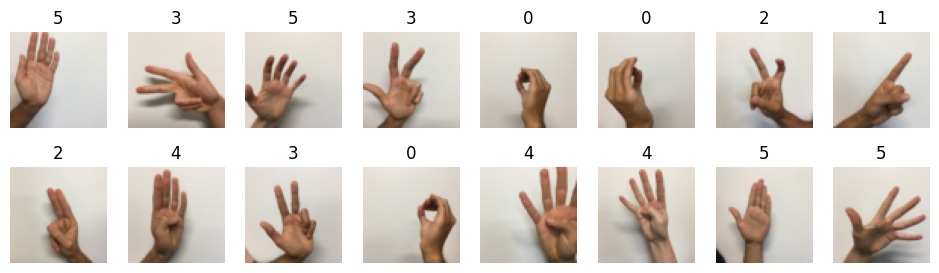

In [4]:
m = X_train.shape[0]
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
for a in ax.flat:
    random_index = np.random.randint(m)# pick a random training data
    a.imshow(X_train[random_index])
    a.set_title(y_train[random_index])
    a.set_axis_off()

plt.show()

# ResNet blocks

## Identity block
Identity block is constructed assuming that the input and output activations have the same dimensions. We use three hidden layers in each block, so, $a^{[\ell]}$ and $a^{[\ell+2]}$ have the same dimensions, where $a$ and $\ell$ denote activation and layer index, respectively. We consider the following architecture for the identity block:

**Main path**
1. 
- Conv2D: $F_1$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis
- ReLU activation

2. 
- Conv2D: $F_2$ $f\times f$ filters with stride $1$ and same padding
- BatchNormalization across the number of channels axis
- ReLU activation

3. 
- Conv2D: $F_3$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis

**Add shortcut**
- Add(): $a^{[\ell]}+z^{[\ell+2]}$
- ReLU activation

In [131]:
def identity_block(X, f, nfilters, initializer=random_uniform):
    """
    Input:
    X: input activation shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f: filter window for the middle conv layer; integer
    nfilters: number of filters for the hidden conv layers; list of integers
    training: True (default): Behave in training mode; False: Behave in inference mode
    initializer: to set up the initial weights of a layer. default = tensorflow.keras.initializers.random_uniform
    
    Output:
    X: outout activation
    """
    
    F1, F2, F3 = nfilters
    X_shortcut = X
    
    ### Main path
    # Stage 1
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 3
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    
    ### Add
    X = tfl.Add()([X,X_shortcut])
    X = tfl.Activation('relu')(X)

    return X

## Convolution block
Convolution block will be used when the input and output activations do not have the same dimensions. We simply convolve the input in the shortcut path to make the dimensions match.

**Main path**
1. 
- Conv2D: $F_1$ $1\times 1$ filters with stride $s$ and valid padding
- BatchNormalization across the number of channels axis
- ReLU activation

2. 
- Conv2D: $F_2$ $f\times f$ filters with stride $1$ and same padding
- BatchNormalization across the number of channels axis
- ReLU activation

3. 
- Conv2D: $F_3$ $1\times 1$ filters with stride $1$ and valid padding
- BatchNormalization across the number of channels axis

**Shortcut path**
- Conv2D: $F_3$ $1\times 1$ filters with stride $s$ and valid padding
- BatchNormalization across the number of channels axis

**Add shortcut**
- Add(): $a^{[\ell]}+z^{[\ell+2]}$
- ReLU activation

In [132]:
def convolutional_block(X, f, nfilters, s = 2, initializer=random_uniform):
    """
    Input:
    Input:
    X: input activation shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f: filter window for the middle conv layer; integer
    nfilters: number of filters for the hidden conv layers; list of integers
    s: stride in the first conv of the main path and the shortcut block
    training: True (default): Behave in training mode; False: Behave in inference mode
    initializer: to set up the initial weights of a layer. default = tensorflow.keras.initializers.random_uniform
    
    Output:
    X: outout activation
    """
    
    F1, F2, F3 = nfilters
    X_shortcut = X

    ### Main path
    
    # Stage 1
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)
    
    # Stage 2
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    X = tfl.Activation('relu')(X)

    # Stage 3
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training=True)
    
    ### Shortcut path
    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = -1)(X_shortcut, training=True)
    
    ### Add
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

# Network
The details of the netwrok is provided below (inspired by the course):

1. 
Zero-padding pads the input with a pad of (3,3)

2. 
- Conv2D: $64$ $7\times 7$ filters with stride $2$ 
- BatchNormalization across the number of channels axis
- MaxPooling2D: $3\times 3$ window and a stride $2$
3. 
- Conv Block: $F=[64,64,256]$, filter $3\times 3$, $s=1$
- 2 Identity (ID) blocks: $F=[64,64,256]$, filter $3\times 3$
4. 
- Conv Block: $F=[128,128,512]$, filter $3\times 3$, $s=2$
- 3 Identity (ID) blocks: $F=[128,128,512]$, filter $3\times 3$
5. 
- Conv Block: $F=[256,256,1024]$, filter $3\times 3$, $s=2$
- 5 Identity (ID) blocks: $F=[256,256,1024]$, filter $3\times 3$
6. 
- Conv Block: $F=[512,512,2048]$, filter $3\times 3$, $s=2$
- 2 Identity (ID) blocks: $F=[512,512,2048]$, filter $3\times 3$
7. 
- AveragePooling2D: $2\times 2$ window
- Faltten()
- The Fully Connected (Dense) layer to softmax

In [133]:
def my_ResNet(input_shape = (64, 64, 3), nclasses = 6):
    X_input = tfl.Input(input_shape)

    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = random_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3, trainable=False)(X, training=True)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    X = convolutional_block(X, 3, [64, 64, 256], 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, 3, [128, 128, 512], 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, 3, [256, 256, 1024], 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, 3, [512, 512, 2048], 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    X = tfl.Flatten()(X)
    X = tfl.Dense(units = nclasses, activation='softmax',name='output-layer',kernel_initializer = random_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

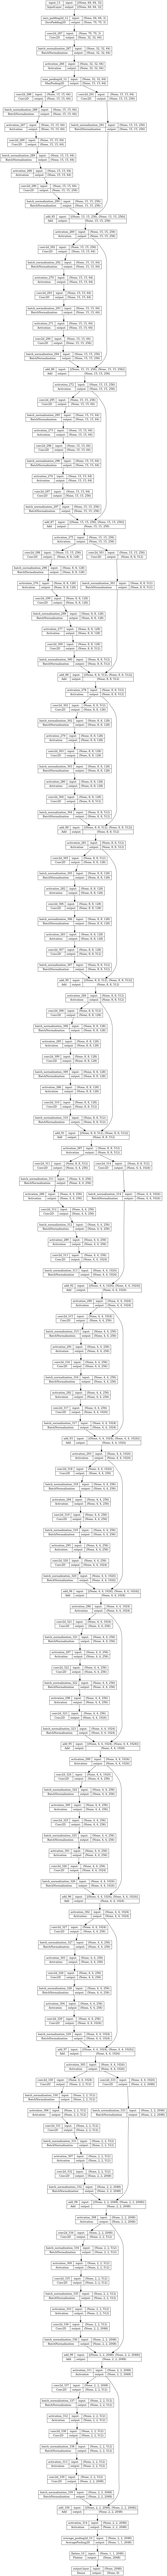

In [134]:
model = my_ResNet(input_shape = (64, 64, 3), nclasses = 6)
tf.keras.utils.plot_model(model, "ResNet-sign-language.png", show_shapes=True)

In [135]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 70, 70, 3)   0           ['input_13[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_287 (Conv2D)            (None, 32, 32, 64)   9472        ['zero_padding2d_12[0][0]']      
                                                                                                  
 batch_normalization_287 (Batch  (None, 32, 32, 64)  256         ['conv2d_287[0][0]']      

 activation_274 (Activation)    (None, 15, 15, 64)   0           ['batch_normalization_296[0][0]']
                                                                                                  
 conv2d_297 (Conv2D)            (None, 15, 15, 256)  16640       ['activation_274[0][0]']         
                                                                                                  
 batch_normalization_297 (Batch  (None, 15, 15, 256)  1024       ['conv2d_297[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_87 (Add)                   (None, 15, 15, 256)  0           ['batch_normalization_297[0][0]',
                                                                  'activation_272[0][0]']         
                                                                                                  
 activatio

                                                                                                  
 add_90 (Add)                   (None, 8, 8, 512)    0           ['batch_normalization_307[0][0]',
                                                                  'activation_281[0][0]']         
                                                                                                  
 activation_284 (Activation)    (None, 8, 8, 512)    0           ['add_90[0][0]']                 
                                                                                                  
 conv2d_308 (Conv2D)            (None, 8, 8, 128)    65664       ['activation_284[0][0]']         
                                                                                                  
 batch_normalization_308 (Batch  (None, 8, 8, 128)   512         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
          

 conv2d_318 (Conv2D)            (None, 4, 4, 256)    262400      ['activation_293[0][0]']         
                                                                                                  
 batch_normalization_318 (Batch  (None, 4, 4, 256)   1024        ['conv2d_318[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_294 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_318[0][0]']
                                                                                                  
 conv2d_319 (Conv2D)            (None, 4, 4, 256)    590080      ['activation_294[0][0]']         
                                                                                                  
 batch_normalization_319 (Batch  (None, 4, 4, 256)   1024        ['conv2d_319[0][0]']             
 Normaliza

                                                                                                  
 activation_304 (Activation)    (None, 4, 4, 256)    0           ['batch_normalization_328[0][0]']
                                                                                                  
 conv2d_329 (Conv2D)            (None, 4, 4, 1024)   263168      ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_329 (Batch  (None, 4, 4, 1024)  4096        ['conv2d_329[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_97 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_329[0][0]',
                                                                  'activation_302[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 add_100 (Add)                  (None, 2, 2, 2048)   0           ['batch_normalization_339[0][0]',
                                                                  'activation_311[0][0]']         
                                                                                                  
 activation_314 (Activation)    (None, 2, 2, 2048)   0           ['add_100[0][0]']                
                                                                                                  
 average_pooling2d_10 (AverageP  (None, 1, 1, 2048)  0           ['activation_314[0][0]']         
 ooling2D)                                                                                        
                                                                                                  
 flatten_1

In [136]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)

In [137]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
34/34 [==============================] - 30s 586ms/step - loss: 1.7465 - accuracy: 0.4926
Epoch 2/20
34/34 [==============================] - 20s 594ms/step - loss: 0.6019 - accuracy: 0.7954
Epoch 3/20
34/34 [==============================] - 20s 596ms/step - loss: 0.5721 - accuracy: 0.8324
Epoch 4/20
34/34 [==============================] - 21s 610ms/step - loss: 0.3828 - accuracy: 0.8759
Epoch 5/20
34/34 [==============================] - 21s 606ms/step - loss: 0.2704 - accuracy: 0.9148
Epoch 6/20
34/34 [==============================] - 21s 617ms/step - loss: 0.2176 - accuracy: 0.9389
Epoch 7/20
34/34 [==============================] - 20s 577ms/step - loss: 0.1725 - accuracy: 0.9463
Epoch 8/20
34/34 [==============================] - 19s 570ms/step - loss: 0.0668 - accuracy: 0.9741
Epoch 9/20
34/34 [==============================] - 20s 595ms/step - loss: 0.1316 - accuracy: 0.9694
Epoch 10/20
34/34 [==============================] - 20s 600ms/step - loss: 0.1201 - accura

# Model evaluation by test data

## model.evaluate()

In [138]:
eval = model.evaluate(X_test, y_test, verbose=0)
print(f"accuracy = {eval[1]*100:.2f}%")

accuracy = 91.67%


## model.predict()

In [144]:
m = X_test.shape[0]
yhat = []
for i in range(m):
    predictions = model.predict(np.expand_dims(X_test[i], axis=0), verbose=0)
    yhat.append(np.argmax(predictions))
    
print(f"accuracy = {np.mean(yhat==y_test)*100:.2f}%")

accuracy = 64.17%


**Note** how different the values are. This is do to the BatchNormalization layers. Distribution of data in the test and train data sets are identical. Therefore, one way to get around this problem is to pass the entire test data to the model.predict. You can check this by changing the number_data below. When it is set equal to $m$ total number of test data entries, model.predict() gives the same accuracy as that of the model.evaluate().

In [162]:
number_data = m
predictions = model.predict(X_test[:number_data], verbose=0)
yhat = np.argmax(predictions, axis=1)
accuracy = np.mean(yhat == y_test[:number_data])
print(f"accuracy = {accuracy*100:.2f}%")

accuracy = 91.67%


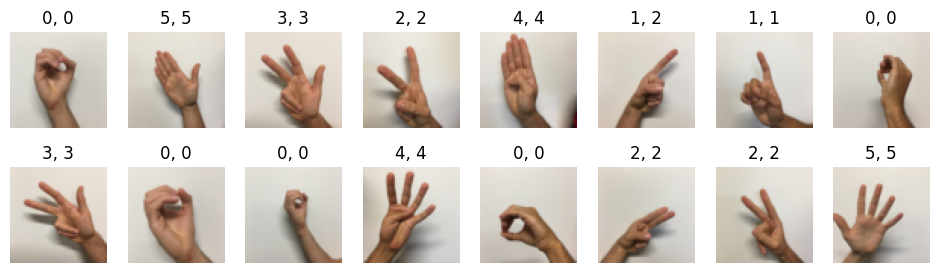

In [163]:
m = X_test.shape[0]
fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, hspace=0.4)
for a in ax.flat:
    random_index = np.random.randint(m)# pick a random test data
    a.imshow(X_test[random_index])
    a.set_title(f"{y_test[random_index]}, {yhat[random_index]}")
    a.set_axis_off()

plt.show()

# Testing the model with a new image
But what if we need to predict a new case? As you can see below, the model does a crappy job in predicting!

digit = 0


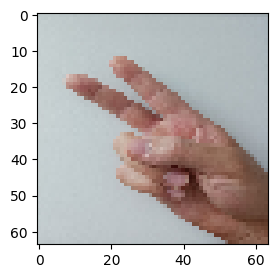

In [177]:
from tensorflow.keras.preprocessing import image
img_path = './data/sign-digit-image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
X_img = np.expand_dims(image.img_to_array(img), axis=0)/255
plt.figure(figsize=(3,3))
plt.imshow(img)
prediction = model.predict(X_img,verbose=0)
print(f"digit = {np.argmax(prediction)}")